<a href="https://colab.research.google.com/github/CRM48/AIML425-A2/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 0, Loss: 0.7297
Step 100, Loss: 0.0826
Step 200, Loss: 0.0069
Step 300, Loss: 0.0092
Step 400, Loss: 0.0070
Step 500, Loss: 0.0060
Step 600, Loss: 0.0037
Step 700, Loss: 0.0069
Step 800, Loss: 0.0035
Step 900, Loss: 0.0068


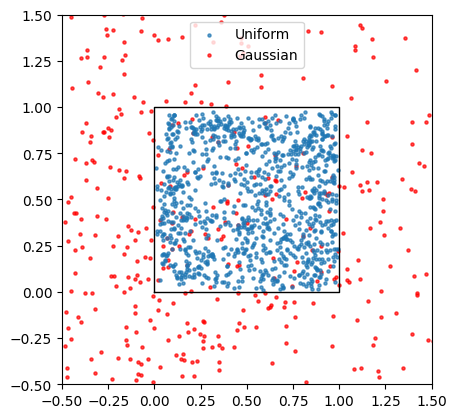

In [35]:
import sys
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Model 1, 2D Gaussian to 2D uniform data
class ToUniformModel(nn.Module):
  def __init__(self, activation_function=nn.ReLU()):
    super(ToUniformModel, self).__init__()
    self.net = nn.Sequential(
         nn.Linear(2, 20),
         activation_function,
         nn.Linear(20, 20),
         activation_function,
         nn.Linear(20, 2),
         nn.Sigmoid() # Ensures data is between 0-1
     )

  def forward(self, x):
    return self.net(x)


def gaussian_kernel(x, y, sigma=0.2):
    # Add dimensions to allow for vector operations
    x_exp = x.unsqueeze(1)
    y_exp = y.unsqueeze(0)
    diff = x_exp - y_exp
    dist_sq = torch.sum(diff ** 2, dim=2)
    # Return exp((||x-y||^2) / (2σ^2))
    return torch.exp(-dist_sq / (2 * sigma ** 2))

def mmd_loss(x, y, sigma=0.2):
    Kxx = gaussian_kernel(x, x, sigma)
    Kyy = gaussian_kernel(y, y, sigma)
    Kxy = gaussian_kernel(x, y, sigma)
    ## Return output of mmd loss formula
    return Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()


# Create model and optimizer
net = ToUniformModel()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training
batch_size = 256
for step in range(1000):
    # Generate inputs, predictions and uniform distribution
    normal = torch.randn(batch_size, 2)
    uniform = torch.rand(batch_size, 2)
    predictions = net(normal)

    # Compute loss comparing predictions to uniform distribution
    loss = mmd_loss(predictions, uniform, sigma=0.2)

    # Backpropogate
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % 100 == 0:
      print(f"Step {step}, Loss: {loss.item():.4f}")


# Generate predictions using final model
with torch.no_grad():
    normal = torch.randn(1000, 2)
    predictions = net(normal)

plt.scatter(predictions[:,0], predictions[:,1], label='Uniform', s=5, alpha=0.7, zorder=2)
plt.scatter(normal[:,0], normal[:,1], label='Gaussian', color='red', s=5, alpha=0.7, zorder=1)

plt.plot([0,1,1,0,0], [0,0,1,1,0], color='black', linewidth=1)
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.show()